In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / (1024 ** 2) 
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / (1024 ** 2)
    print(f"start_mem Memory usage of df_train: {start_mem:.2f} MB")
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [23]:
df_train_trans = pd.read_csv('../input/train_transaction.csv')
df_train_identity = pd.read_csv('../input/train_identity.csv')

df_train = df_train_trans.merge(df_train_identity, how='left', on='TransactionID')

print(df_train.shape)
del df_train_trans, df_train_identity


(590540, 434)


In [24]:
df_train["isFraud"].value_counts()

isFraud
0    569877
1     20663
Name: count, dtype: int64

In [25]:
df_train = reduce_mem_usage(df_train)       

start_mem Memory usage of df_train: 2567.09 MB
Mem. usage decreased to 1257.69 Mb (51.0% reduction)


In [26]:
# Label encoding for categorical features
for col in df_train.select_dtypes(include='object').columns:
    lbl = LabelEncoder()
        
    encoded_values = lbl.fit_transform(df_train[col]) 
        
    #Replace the NaN (which becomes -1 after LabelEncoding) with -999
    encoded_values[df_train[col].isnull()] = -999
        
    # Step 5: Assign the encoded values back to the column
    df_train[col] = encoded_values

df_train.fillna(-999, inplace=True)
percent_missing = (df_train == -999).mean() * 100

# Identify columns where more than 50% of the values are missing
cols_to_drop = percent_missing[percent_missing > 50].index

cols_to_keep = ['R_emaildomain', 'DeviceInfo', 'DeviceType', 'D5', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14', 'dist1', 'dist2', 'id_31', 'id_30', 'M5', 'M7', 'M8', 'M9']
cols_to_drop = cols_to_drop.drop(cols_to_keep, errors='ignore') # Exclude 'R_emaildomain' from dropping

# Drop these columns
df_train_cleaned = df_train.drop(columns=cols_to_drop)

remove_columns = ['M4']
# Drop these columns
df_train_cleaned = df_train_cleaned.drop(columns=remove_columns)

# Display the cleaned dataframe
print(f"Columns removed: {cols_to_drop}")
print(f"Shape of the cleaned dataframe: {df_train_cleaned.shape}")

Columns removed: Index(['V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146',
       'V147',
       ...
       'id_27', 'id_28', 'id_29', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36',
       'id_37', 'id_38'],
      dtype='object', length=195)
Shape of the cleaned dataframe: (590540, 238)


In [27]:
df_train_cleaned = df_train_cleaned.drop('TransactionID', axis=1)

# Select only numerical columns
X_train = df_train_cleaned.drop(columns=['isFraud'])
y_train = df_train_cleaned['isFraud']

# Train-test split (80% train, 20% validation)
# X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [28]:
majority_class_indices = np.where(y_train == 0)[0]
minority_class_indices = np.where(y_train == 1)[0] 

oversampled_minority_class_indices = np.random.choice(minority_class_indices, len(majority_class_indices), replace=True)
balanced_indices = np.concatenate([majority_class_indices, oversampled_minority_class_indices])

np.random.shuffle(balanced_indices)
X_train_resampled = X_train.iloc[balanced_indices]
y_train_resampled = y_train.iloc[balanced_indices]

In [29]:
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42, stratify=y_train_resampled)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_val_scaled = scaler.transform(X_val)

In [9]:
df_train["isFraud"].value_counts()

isFraud
0    569877
1     20663
Name: count, dtype: int64

In [39]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [51]:
import tensorflow as tf

# Build a Neural Network Model
model = Sequential()

# Input Layer
model.add(Input(shape=(X_train_scaled.shape[1],)))

# Hidden Layers
model.add(Dense(80, activation='relu'))
model.add(Dense(600, activation='relu'))
model.add(Dense(64, activation='relu'))

# Output Layer
model.add(Dense(1, activation='sigmoid')) 

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.F1Score(threshold=0.5)]
)


Epoch 1/25
11398/11398 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - f1_score: 0.7631 - loss: 0.4802 - val_f1_score: 0.8145 - val_loss: 0.4016
Epoch 2/25
11398/11398 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - f1_score: 0.8172 - loss: 0.3856 - val_f1_score: 0.8306 - val_loss: 0.3505
Epoch 3/25
11398/11398 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - f1_score: 0.8504 - loss: 0.3250 - val_f1_score: 0.8658 - val_loss: 0.2948
Epoch 4/25
11398/11398 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - f1_score: 0.8730 - loss: 0.2822 - val_f1_score: 0.8798 - val_loss: 0.2701
Epoch 5/25
11398/11398 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - f1_score: 0.8903 - loss: 0.2480 - val_f1_score: 0.8877 - val_loss: 0.2517
Epoch 6/25
11398/11398 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - f1_score: 0.9019 - loss: 0.2251 - val_f1_score: 0.9074 - val_loss: 0.2201
Epoch 7/25
11398/11398 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - f1_score: 0.9114 - loss: 0.2070 - val_f1_score: 0.9096 - val_loss: 0.2096
Epoch 8/25
11398/11398 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - f1_score: 

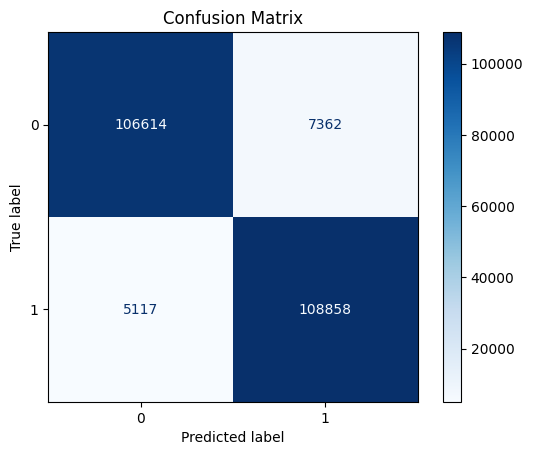

In [52]:
history = model.fit(X_train_scaled, y_train_final, 
                    epochs=25,                   # Allow for many, early stopping will cut it short
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[early_stopping],  # <- This is what enables early stopping
                    verbose=1
                    )

y_train_pred_proba = model.predict(X_train_scaled)
y_train_pred = (y_train_pred_proba > 0.5).astype(int)
print("Training Performance:\n", classification_report(y_train_final, y_train_pred))

# Predictions on validation data
y_val_pred_proba = model.predict(X_val_scaled)
y_val_pred = (y_val_pred_proba > 0.5).astype(int)
print("Validation Performance:\n", classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

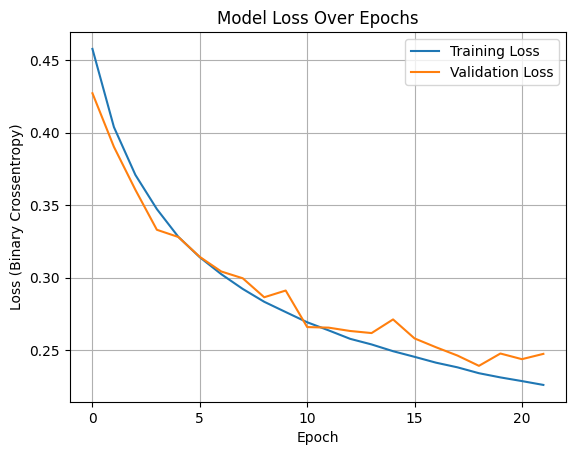

In [50]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (Binary Crossentropy)')
plt.legend()
plt.grid(True)
plt.show()

Dobry model - nizsie je vyuzita optuna

In [31]:
import keras_tuner as kt

def model_builder(hp):
  model = tf.keras.Sequential()
  model.add(Input(shape=(X_train_scaled.shape[1],)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units1 = hp.Int('units1', min_value=16, max_value=64, step=8)
  model.add(tf.keras.layers.Dense(units=hp_units1, activation='relu'))

  hp_units2 = hp.Int('units2', min_value=16, max_value=64, step=8)
  model.add(tf.keras.layers.Dense(units=hp_units2, activation='relu'))

  hp_units3 = hp.Int('units3', min_value=16, max_value=64, step=8)
  model.add(tf.keras.layers.Dense(units=hp_units3, activation='relu'))

  # Output layer for binary classification
  model.add(Dense(1, activation='sigmoid')) 
  
  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  f1 = tf.metrics.F1Score(threshold=0.5)
  f1.__name__ = "f1_score"  # <-- manually give it a name!
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='binary_crossentropy',
                metrics=[f1]
                )

  return model


In [32]:
X_train_scaled.shape

(911803, 236)

In [33]:
import os
os.makedirs(r'C:\kmy_dir', exist_ok=True)

tuner = kt.Hyperband(
    model_builder,
    objective=kt.Objective("val_f1_score", direction="max"), 
    max_epochs=25,
    factor=3,
    directory=r'C:\kmy_dir',
    project_name='intro_to_kt'
)


tuner.search(
    X_train_scaled,  
    y_train_final,   
    epochs=100,
    validation_split=0.2, 
    callbacks=[early_stopping],  # Apply early stopping during the search
    verbose=1
)

Reloading Tuner from C:\kmy_dir\intro_to_kt\tuner0.json


In [34]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

In [38]:
print("Best hyperparameters:")
for hp_name in best_hps.values.keys():
    print(f"{hp_name}: {best_hps.get(hp_name)}")

Best hyperparameters:
units: 512
learning_rate: 0.0001
units1: 256
units2: 416
units3: 480
tuner/epochs: 25
tuner/initial_epoch: 9
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0018


Epoch 1/25
11398/11398 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - f1_score: 0.7586 - loss: 0.4881 - val_f1_score: 0.7973 - val_loss: 0.4171
Epoch 2/25
11398/11398 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - f1_score: 0.8067 - loss: 0.4045 - val_f1_score: 0.8260 - val_loss: 0.3730
Epoch 3/25
11398/11398 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - f1_score: 0.8327 - loss: 0.3612 - val_f1_score: 0.8370 - val_loss: 0.3587
Epoch 4/25
11398/11398 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - f1_score: 0.8523 - loss: 0.3247 - val_f1_score: 0.8644 - val_loss: 0.3008
Epoch 5/25
11398/11398 ━━━━━━━━━━━━━━━━━━━━ 48s 4ms/step - f1_score: 0.8673 - loss: 0.2960 - val_f1_score: 0.8585 - val_loss: 0.3001
Epoch 6/25
11398/11398 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - f1_score: 0.8802 - loss: 0.2708 - val_f1_score: 0.8891 - val_loss: 0.2557
Epoch 7/25
11398/11398 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - f1_score: 0.8918 - loss: 0.2474 - val_f1_score: 0.8935 - val_loss: 0.2462
Epoch 8/25
11398/11398 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step - f1_score: 

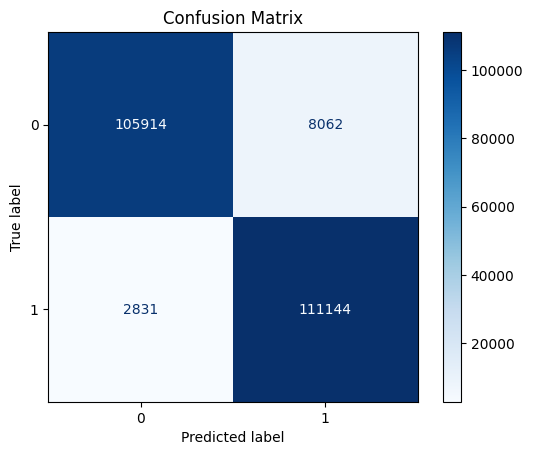

In [ ]:
history = model.fit(X_train_scaled, y_train_final, 
                    epochs=25,                   # Allow for many, early stopping will cut it short
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[early_stopping],  # <- This is what enables early stopping
                    verbose=1
                    )

# Predictions on training data
y_train_pred_proba = model.predict(X_train_scaled)
y_train_pred = (y_train_pred_proba > 0.5).astype(int)
print("Training Performance:\n", classification_report(y_train_final, y_train_pred))

# Predictions on validation data
y_val_pred_proba = model.predict(X_val_scaled)
y_val_pred = (y_val_pred_proba > 0.5).astype(int)
print("Validation Performance:\n", classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

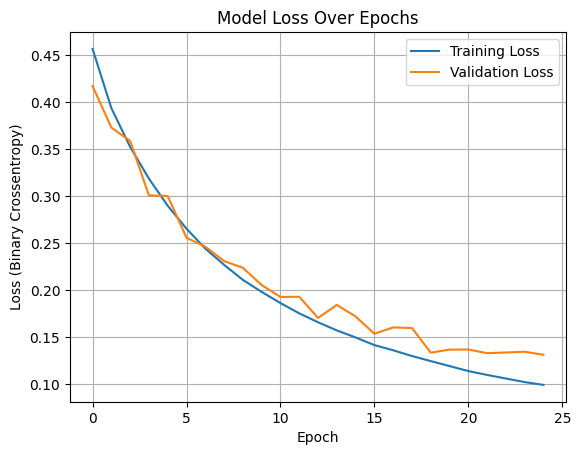

In [37]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (Binary Crossentropy)')
plt.legend()
plt.grid(True)
plt.show()